<p style="color: #006bb3; font-size: 16px; font-style: italic; text-align: justify;">
    <p2 style="font-size: 32px;">CANCELACIÓN HOTELERA</p2></br>
    <p3 style="font-size: 24px;">Desarrollo de un modelo Machine Learning para la clasificación de reservas de alojamiento según su probabilidad de cancelación.</p3></br></br>
    <p4 style="color: black; font-size: 18px;">Proyecto desarrollado por Antonio García Valverde</p4>
</p>

---

<p align="center";">
  <img src="./src/img/novacancylite.png" alt="imagen" style=width: 100%;">
</p>

</br></br>

### Indice

1. [Planteamiento inicial](#1-Planteamiento-inicial)
    - [Problema de negocio](#11-Problema-de-negocio) 
    - [Problema técnico](#12-Problema-tecnico) 
2. [Revisión de datos proporcionados](#2-Revision-de-datos-proporcionados)  
3. [Análisis exploratorio (EDA)](#3-Analisis-exploratorio-(EDA)) 
    - [Carga de datos y separación Train/Test](#31-Carga-de-datos-y-separacion-Train/Test)
    - [Descripción de las variables](#32-Descripcion-de-las-variables)
    - [Visualización de variables](#33-Visualizacion-de-variables)
        - [Variable_target](#331-Variable-target)
        - [Resto de features](#332-Resto-de-features)
        - [Primeras conclusiones](#333-Primeras-conclusiones)
    - [Visualización detallada y transformaciones](#34-Visualizacion-detallada-y-transformaciones)
        - [Conclusiones y procesamiento de datos](#341-Conclusiones-y-procesamiento-de-datos)
    - [Relación estadística](#35-Relacion-estadistica)
4. [Modelo ML](#4-Modelo-ML)  
    - [División de subconjuntos X,y](#41-Division-de-subconjuntos-X,y)  
    - [Baseline y selección de modelo](#42-Baseline-y-seleccion-de-modelo)  
    - [Balanceo de target](#43-Balanceo-de-target)  
    - [Optimización de hiperparámetros](#44-Optimizacion-de-hiperparametros)
5. [Guardado del modelo](#5-Guardado-del-modelo)  
    - [Pipeline](#51-Pipeline)  
    - [Guardado](#52-Guardado)

---


## 1 **Planteamiento inicial**
### 1.1 **Problema de negocio**
Una cadena hotelera solicita el desarrollo de un modelo clasificador de las reservas efectuadas en sus alojamientos capaz de anticiparse a una probable cancelación de la reserva.
Los motivos por los que consideran relevante este desarrollo son los siguientes:
* **Anticipación a la pérdida de negocio.**
Una reserva confirmada supone la asignación de un espacio de negocio con las condiciones pactadas.  
En caso de cancelación de esta reserva, la empresa puede contratar de nuevo el espacio, pero la dificultad para encontrar una nueva reserva puede conducir a pérdida total o parcial de negocio para ese espacio.  

* **Políticas de cancelación.**  
Con una buena aproximación a las reservas con alta probabilidad de cancelación, se pueden ajustar las políticas y períodos de cancelación que mantiene la empresa.
* **Elaboración de otros informes.**  
Otros análisis derivados de la clasificación pueden concluir en una mejora respecto a los períodos y clientes objetivos para futuras promociones.  


### 1.2 **Problema tecnico**
Para dar respuesta al problema de negocio planteado se propone el desarrollo de un modelo que reconozca las características de las reservas canceladas, puesto que se cuenta con unos datos previos recopilados por el negocio entre los años 2015 y 2018 con una variable que indica la confirmación o cancelación de la reserva, y que aplique ese reconocimiento para determinar la conclusión más probable de las futuras reservas.  
Se trata por tanto de un **problema supervisado de clasificación**, y se aplicarán los modelos correspondientes a ese punto de partida.  

Para evaluar el modelo se empleará una métrica que tenga en cuenta el número global de registros mal clasificados, independientemente de si trata de falsos positivos o falsos negativos, porque ambos casos pueden ser perjudiciales para el rendimiento del negocio.  
La métrica que se empleará en la selección y evaluación del modelo será **'balanced_accuracy'**.

[Indice](#indice)

---

## 2 **Revision de datos proporcionados**
En el período 2015-2018 la empresa llevó a cabo una recopilación de datos para aplicar a estudios posteriores, conformando dos conjuntos de registros, denominados **Hotel_Bookings** y **Hotel_Reservations**.  
Partiendo de esas dos fuentes diferentes, con criterios equivalentes pero no iguales respecto a la nomenclatura y el número de variables, el primer paso en el desarrollo será inspeccionar ambos dataset para seleccionar las columnas de trabajo y unificar la nomenclatura para posteriormente unir ambos conjuntos en un único dataset de trabajo.   

Tras una primera exploración se puede observar, como ya nos había anticipado negocio, que los dataset tienen un número dispar de columnas, aunque el dataset con más columnas cuenta entre ellas con el equivalente de las columnas contenidas en el dataset con menos variables.  
La otra cuestión es su nomenclatura, que varía ligeramente entre las columnas coincidentes.  
Se procede a renombrar las columnas, eliminar las columnas no coincidentes, simplificar de nuevo la nomenclatura y unir los dataset.  

En una segunda revisión, se procede con la limpieza de los datos con los siguientes pasos:
* Eliminación de los registros con valores nulos de la columna *'children'*.
* Eliminación de los registros con valor *Undefined* en la variable *'meal_plan'*.
* Suma total del número de reservas del cliente.
* Se uniformizan los valores de las columnas coincidentes.
* Creación de una columna de fecha de reserva y eliminación de las columnas de fechas anteriores.
* Eliminación de columnas *'room_type'* y *'ms_type'*, por falta de protocolo en la toma de datos. 
* Reordenamiento de columnas y reindex a los registros. 

Se crean finalmente dos dataset de trabajo, uno sin registros duplicados, llamado *'Data_Reservas'*, y otro manteniendo los registros duplicados, llamado ***'Data_Reservas_full'***.
En pasos del proyecto posteriores se decidirá trabajar con el dataset completo, con registros duplicados, porque esos valores repetidos se han producido al eliminar los campos que identificaban de forma única a cada registro (nombre de cliente, identificador de reserva), pero se trataba originalmente de registros únicos con características repetidas, que pueden ayudar en la precisión del modelo como se ha comprobado posteriormente.  

El proceso de limpieza y montaje del dataset resultante puede seguirse en el **[notebook](./src/notebooks/1_notebook_preparacion_dataset.ipynb)** correspondiente a la preparación del dataset.  

[Indice](#Indice)

---

## 3 **Analisis exploratorio (EDA)**

### 3.1 **Carga de datos y separacion Train/Test**

In [38]:
# Carga de las librerías necesarias en el proyecto
import os, sys
sys.path.append(os.path.abspath("../"))
import numpy as np
import optuna
import pandas as pd
import pickle

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.utils.bootcampviztools import *
from src.utils.toolbox import *

In [39]:
# Se carga el dataset de trabajo
df = pd.read_csv("./src/data/Datos_Reservas_full.csv")

# Se extrae una muestra aleatoria de mil registros y se guarda el archivo, con y sin target
df_muestra = df.sample(1000, random_state = 42)
df_muestra.to_csv("./src/data_sample/muestra_reservas.csv", index = False) 
df_muestra_x = df_muestra.drop(columns = ["canceled"])
df_muestra_x.to_csv("./src/data_sample/muestra_reservas_sin_target.csv", index = False) 

# Se elimina la muestra del dataset original
df = df[~df.isin(df_muestra).all(axis=1)]

# Se separan los conjuntos de datos de train y test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

# Se identifica el target
target = "canceled"

# Se visualiza la información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152355 entries, 0 to 153354
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   daily_price     152355 non-null  float64
 1   lead_time       152355 non-null  int64  
 2   adults          152355 non-null  int64  
 3   children        152355 non-null  int64  
 4   repeated_guest  152355 non-null  int64  
 5   total_book      152355 non-null  int64  
 6   pre_cancel      152355 non-null  int64  
 7   pre_not_cancel  152355 non-null  int64  
 8   arr_date        152355 non-null  object 
 9   arr_week        152355 non-null  int64  
 10  week_nights     152355 non-null  int64  
 11  weekend_nights  152355 non-null  int64  
 12  meal_plan       152355 non-null  object 
 13  parking         152355 non-null  int64  
 14  special_req     152355 non-null  int64  
 15  canceled        152355 non-null  int64  
dtypes: float64(1), int64(13), object(2)
memory usage: 19.8+ MB


### 3.2 **Descripcion de las variables**
<div style="background-color: AliceBlue;">

| Variable | Tipo | Descripción |
|:---------|:----:|:------------|
| daily_price | float64 | Precio diario medio de la reserva efectuada, en euros. |
| lead_time | int64 | Días transcurridos entre la fecha de reserva y el día previsto de llegada. | 
| adults | int64 | Número de huéspedes adultos de la reserva. |
| children | int64 | Número de huéspedes menores de edad en la reserva. | 
| repeated_guest | int64 |Variable que indica si el huésped ha sido cliente anteriormente (0 = No, 1 = Sí). | 
| total_book | int64 | Número total de reservas previas del cliente, si las hubiera. | 
| pre_cancel | int64 | Número total de cancelaciones previas del cliente. | 
| pre_not_cancel | int64 | Número total de reservas confirmadas previas del cliente. | 
| arr_date | datetime64 | Fecha de comienzo de la reserva. |
| arr_week | int64 | Semana de comienzo de la reserva. |
| week_nights | int64 | Número total de noches entre semana (lunes-viernes) que contiene la reserva. |
| weekend_nights | int64 | Número total de noches de fin de semana (sábado-domingo) que contiene la reserva.|
| meal_plan | object | Variable que especifica el tipo de menú enlazado a la reserva (SC = Apartamento, RO = Solo alojamiento, BB = Alojamiento y desayuno, HB = Media pensión, FB = Pensión completa). |
| parking | int64 | Número de plazas de aparcamiento vinculadas a la reserva. |
| special_req | int64 | Número total de peticiones especiales enviadas con la reserva. |
| canceled | int64 | Variable binaria que indica si se trata de una reserva confirmada (0) o cancelada (1). |

</div>

### 3.3 **Visualizacion de variables**

### 3.3.1 Variable target

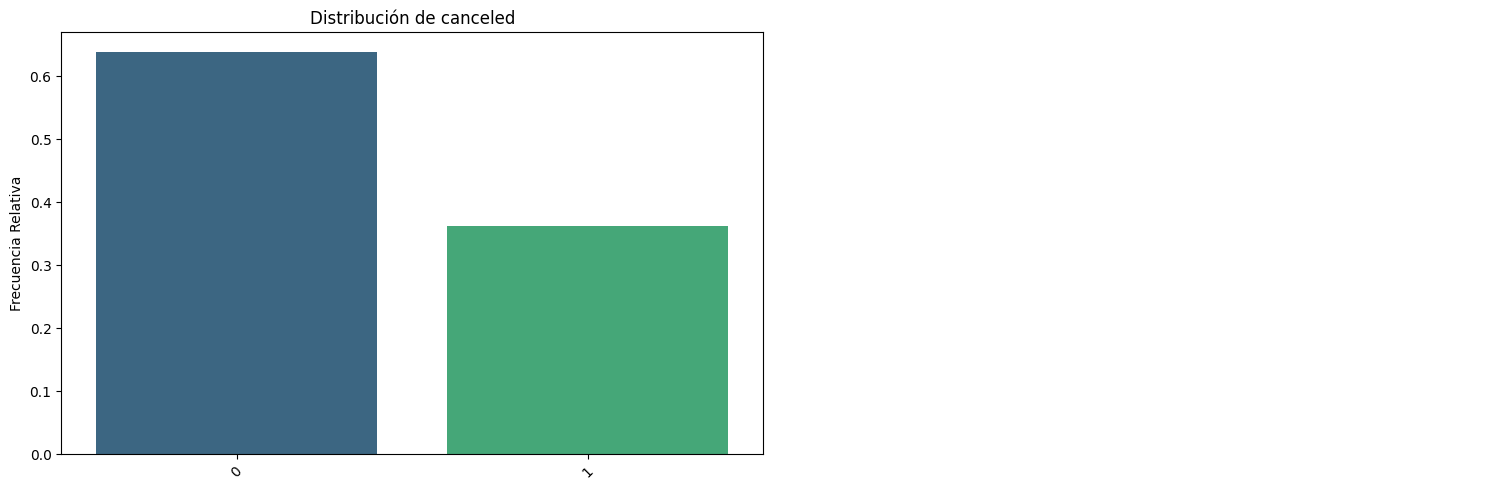

In [40]:
# Se imprime la distribución de frecuencia relativa de la variable 'target' (0 = Confirmada, 1 = Cancelada)
pinta_distribucion_categoricas(train_set, [target], relativa = True)

### 3.3.2 Resto de features

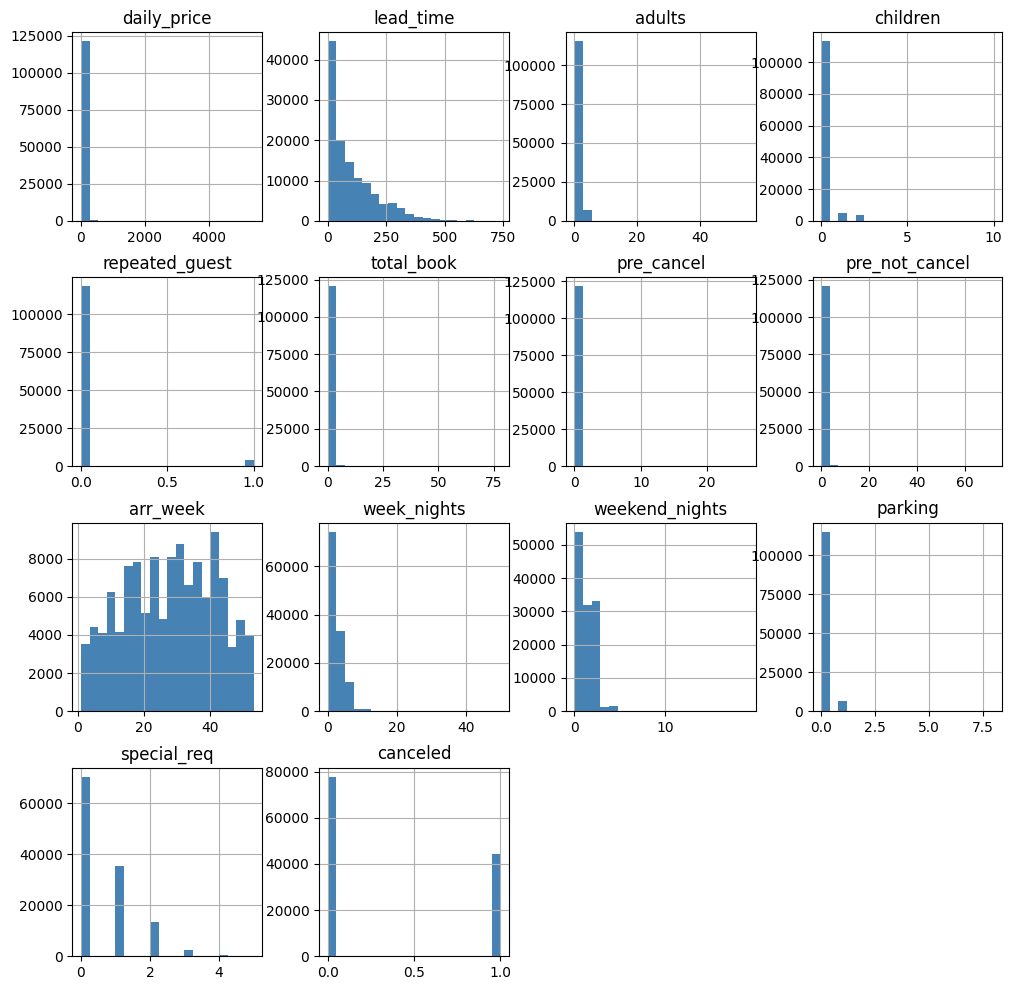

In [41]:
# Se revisa visualmente la distribución de todas las variables
train_set.hist(bins = 20, color = "steelblue", figsize = (12,12));

### 3.3.3 Primeras conclusiones
Mediante una observación superficial del dataset de trabajo al que se aplicarán los diferentes modelos de predicción se ha llegado a las siguientes conclusiones iniciales:
* La variable target está algo descompensada y habrá que decidir si se aplica alguna medida correctora para mitigar la diferencia de datos (oversampling, undersampling).
* Todas las variables son numéricas, lo que facilitará la aplicación de diferentes modelos, aunque aun deben distinguirse las variables numéricas naturales y las variables categóricas que cuentan con números como etiquetas.
* En alguna variables categóricas no binarias o numéricas discretas se aplicarán transformaciones para convertir en binarias según la distribución de valores que tengan.

### 3.4 **Visualizacion detallada y transformaciones**
Todas las variables han sido visualizas de forma individual y combinadas de dos en dos, siempre en relación a la variable target.  
En la mayoría de los casos no se encuentran valores extraños o diferencias relevantes entre los KDE de las reservas confirmadas y canceladas, salvo en alguna excepción que se adjunta a este notebook como complemento visual.  
  
Todo el proceso de análisis exploratorio de datos se puede comprobar **[aquí](./src/notebooks/2_notebook_EDA.ipynb)**. 

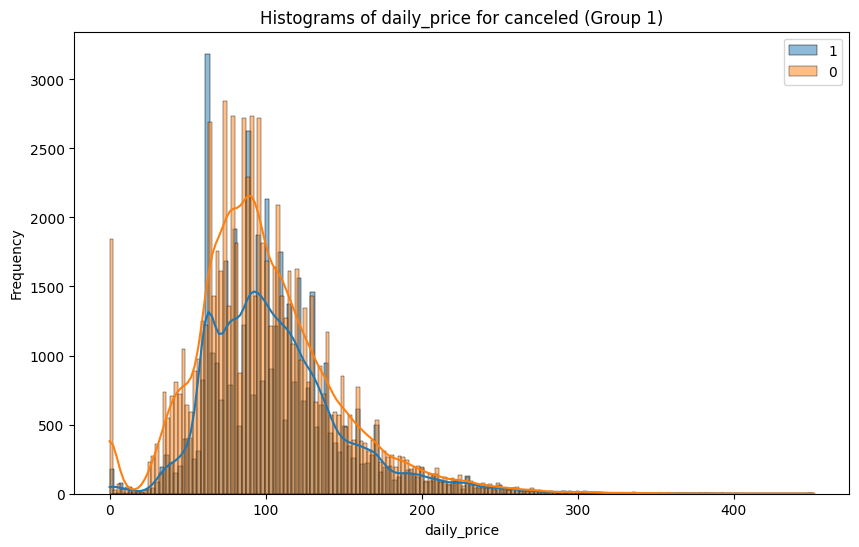

In [42]:
# Distribución de la variable en relación al 'target' (0 = No cancelada, 1 = Cancelada), sin tener en cuenta los outliers para aproximar la vista
plot_grouped_histograms(train_set[train_set.daily_price <= 2000],"canceled", "daily_price",2);

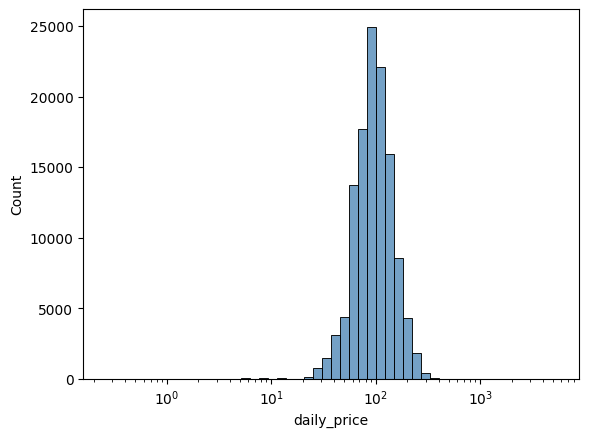

In [43]:
# Gráfico de la variable 'daily_price' con transformación logística
sns.histplot(train_set.daily_price, bins = 50, color = "steelblue", log_scale = 10);

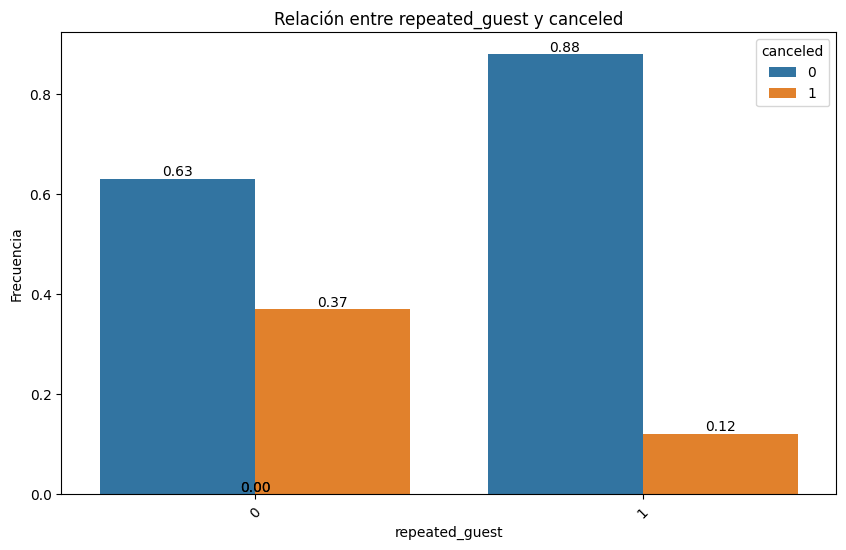

In [44]:
# Gráfico de relación entre 'repeated_guest' y la variable target.
plot_categorical_relationship_fin(train_set, "repeated_guest","canceled", relative_freq = True, show_values = True)

### 3.4.1 Conclusiones y procesamiento de datos
Tras el análisis de las variables se plantean varias preguntas que conducen a las siguientes decisiones de procesamiento de los datos recibidos:

* **canceled (variable target)**  
Como ya se había señalado anteriormente, la variable target se encuentra algo desbalanceada, por lo que en pasos posteriores se probarán los modelos con y sin métodos de balanceo, en este caso con el hiperparámetro **'class_weight'**.

* **daily_price**  
Se encuentran registros con valores de cero o negativos en la variable *'daily_price'*, interpretados como abonos y promociones.  
En los registros sin coste se observa una mayor diferencia de frecuencias con respecto a las cancelaciones, a favor de las reservas no canceladas.  
El dibujo del KDE en las opciones sigue un patrón equivalente, por lo que no parece que el coste diario tenga mucha influencia en el target.  
Se decide eliminar estos valores en el estudio: 
    * El problema de negocio es identificar las características de las reservas potencialmente canceladas, para crear un modelo de predicción que alerte sobre ellas.  
    Que la consecución de la reserva suponga un ingreso o no para el alojamiento no altera la realidad de la pérdida que supone reservar un espacio al que no se le dará uso posterior en caso de cancelación, por lo que en caso de que el dato tenga relación con el 'target', en principio ésta se daría independientemente de que se trate de una oferta o de una reserva convencional.  
    Sin embargo, atendiendo a la poca relación con la vatiable objetivo, se observa además una mayor concentración de reservas no canceladas cuando se trata de una reserva sin coste, por lo que su eliminación conducirá a un modelo más preciso en el resto (la mayoría) de casos, además de suponer un menor desbalanceo respecto a las variables 'adult' y 'target'.   
Aunque aparentemente no parece relevante en los motivos de cancelación de las reservas, se decide mantener la variable aplicando una transformación logística para facilitar el posterior cálculo del modelo.  

* **lead_time**  
La variable *'lead_time'* tiene una distribución lógica, con una relación directa entre el número de registros y el incremento en los días.  
Se puede distinguir además que está muy relacionada con el *'target'*; las frecuencias de cancelación se invierten en diferentes tramos.    
Se eliminarán los registros con *'lead_time'* igual a cero, por consistencia en los datos, porque se entiende que una reserva efectuada el mismo día de la llegada no se cancelará salvo que se trate de un error de inserción de datos. 
Se mantiene la variable, aunque se aplicará una transformación logística en sus valores.

* **adults**  
Los registros con valor cero se mantienen, porque pueden tratarse de reservas de varias habitaciones para una misma familia con dos adultos y varios hijos.  
No parece una variable muy determinante en la predicción de cancelación, puesto que las frecuencias se mantienen equivalentes en los mismos rangos.  
Sí se eliminarán los registros con valor cero coincidente tanto en *'adults'* como en *'children'*, por tratarse de datos inconsistentes.

* **children**  
La distribución es categórica, aunque se agruparán los valores en dos etiquetas, con hijos (1) y sin hijos (0), para transformarla en una variable binaria.  
Se mantiene la variable transformada, aunque no parece que haya mucha influencia en las cancelaciones respecto a si la reserva incluye alojamiento para niños o no.

* **repeated_guest**  
Se trata de una variable binaria sin valores extraños.  
Se observa que si el cliente ya había estado en el establecimiento la probabilidad de cancelación de la reserva es mucho menor.  
Parece que será una variable importante en el modelo de predicción, por lo que se mantiene sin cambios.

* **total_book**  
Se trata de una feature redundante con la variable anterior, que especificaba si el cliente había estado anteriormente.  
Como en otros casos anteriores, se transformará la variable en una binaria con los valores 0 (no hay reservas previas) y 1 (sí hay reservas previas).  
No parece una variable muy relevante, pero se mantiene en cualquier caso.

* **pre_cancel** y **pre_not_cancel**  
Se transforman ambas en categóricas binarias y se mantienen las variables.  
En este caso se observa como resulta determinante respecto a la variable *'target'*; en los casos en que el cliente ha cancelado alguna reserva previa, el porcentaje de reservas canceladas es mayor que el de reservas confirmadas.  
¿Es posible que se deba a cancelaciones derivadas de reservas hechas por agencias? No puede saberse porque la columna *'ms_type'* no contenía datos limpios para concretar esta valoración.

* **arr_date**  
Se observan algunos picos de actividad en fechas determinadas, pero las curvas son equivalentes.  
Se elimina la variable porque la información que puede ofrecer se encuentra en la siguiente variable, con las fechas agrupadas por semanas.

* **arr_week**  
En la gráfica se puede observar cómo hay determinadas semanas en que es mayoritaria la cancelación a pesar de la diferencia de registros entre ambos casos.  
Esta variable se considera relevante y se mantienen los datos.

* **week_nights**  
Se eliminan (si los hubiera) los resultados en los que tanto *'week_nights'* como *'weekend_nights'* son igual a cero, por inconsistencia en los datos.  
Se crea una etiqueta para valores por encima de 5, de forma que las etiquetas finales son 1, 2, 3, 4, 5, 6 (6+).  
Se mantiene la variable

* **weekend_nights**  
Como en el caso anterior, se crea una nueva etiqueta para los valores por encima de 2.  
Las etiquetas resultantes son 0, 1, 2, 3 (3+).  
Se mantiene la variable.

* **meal_plan**  
La variable contiene la mayoría de los resgistros en una de sus etiquetas, pero se aprecia una relación entre las diferentes posibilidades y la variable conductora.  
Se emplea *OrdinalEncoder* para modificar las etiquetas con un orden preestablecido de menor a mayor contenido de restauración.  
Se mantiene la variable.

* **parking**  
Se transforma la variable a una categórica con los valores 0 (sin parking) y 1 (con parking).  
Se mantiene la variable, porque se observa un descenso en las cancelaciones en caso de reservar también el parking.

* **special_req**  
Se mantiene la variable sin cambios, al observarse un descenso en las cancelaciones conforme aumenta el número de peticiones especiales que atender en la reserva.

Todas las transformaciones que implican un **borrado de registros** se han tratado como **imputación de valores** en la función de transformación resultante.  
La función que contiene todos los cambios del procesamiento de datos se encuentra **[aquí](./src/utils/toolbox.py)**.

In [45]:
# Procesamiento de los datos en los conjuntos train/test
train_set = total_transform(train_set)
test_set = total_transform(test_set)

In [46]:
# Se tipifican las variables y se incluyen en las listas correspondientes
df_tip = tipifica_variables(train_set, 30, 0.05)

# Lista de variables categóricas
features_cat = df_tip.loc[(df_tip.tipo_sugerido == "Categorica")|(df_tip.tipo_sugerido == "Binaria")]["nombre_variable"].tolist()
features_cat.remove(target)
print(features_cat)

# Lista de variables numéricas
features_num = df_tip.loc[(df_tip.tipo_sugerido != "Categorica")&(df_tip.tipo_sugerido != "Binaria")]["nombre_variable"].tolist()
print(features_num)

['adults', 'children', 'repeated_guest', 'total_book', 'pre_cancel', 'pre_not_cancel', 'week_nights', 'weekend_nights', 'meal_plan', 'parking', 'special_req']
['daily_price', 'lead_time', 'arr_week']


### 3.5 **Relacion estadistica**

In [47]:
# Se visualiza la relación estadística de las variables categóricas con la variable 'target'
for col in features_cat:
    tabla_contingencia = pd.crosstab(train_set["canceled"], train_set[col])
    chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
    print(f"{col}--{target}: chi2 = {chi2}, p_value = {p}")    

adults--canceled: chi2 = 936.6600228991767, p_value = 8.122161128113841e-194
children--canceled: chi2 = 1.027252054589579, p_value = 0.31080495598840846
repeated_guest--canceled: chi2 = 949.7538925086017, p_value = 1.5005176423003205e-208
total_book--canceled: chi2 = 1869.4471554095499, p_value = 0.0
pre_cancel--canceled: chi2 = 6461.589242860127, p_value = 0.0
pre_not_cancel--canceled: chi2 = 1540.525188947257, p_value = 0.0
week_nights--canceled: chi2 = 995.2123038306023, p_value = 9.702442520479707e-212
weekend_nights--canceled: chi2 = 20.797329218372127, p_value = 0.00011598744559237314
meal_plan--canceled: chi2 = 167.52538731266628, p_value = 3.5524592536632883e-35
parking--canceled: chi2 = 3707.81983766711, p_value = 0.0
special_req--canceled: chi2 = 8731.528877602415, p_value = 0.0


In [48]:
# Se visualiza la relación estadística de las variables numéricas con la variable 'target'
for col in features_num:
    grupo_a = train_set.loc[train_set.canceled == 0][col]
    grupo_b = train_set.loc[train_set.canceled == 1][col]
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
    print(f"{col}--{target}: Estadístico U: {u_stat}, p_value = {p_valor}")

daily_price--canceled: Estadístico U: 1606472818.0, p_value = 1.1481492615593243e-75
lead_time--canceled: Estadístico U: 1068520456.0, p_value = 0.0
arr_week--canceled: Estadístico U: 1715908940.5, p_value = 0.893697372501647


[Indice](#indice)

---

## 4 **Modelo ML**

### 4.1 **Division de subconjuntos X,y**

In [49]:
# Se forman los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = [target], inplace = True)
y_train = train_set[target].copy()

X_test = test_set.copy()
X_test.drop(columns = [target], inplace = True)
y_test = test_set[target].copy()

### 4.2 **Baseline y seleccion de modelo**  
Como se comprueba en el baseline, el algoritmo de **RandomForestClassifier** es el seleccionado, porque ofrece la mejor métrica (**'balance_accuracy'**) escogida para la evaluación.

In [50]:
# Escalado (StandarScaler) aplicado a Logistic Regression
model_names = ["DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
clf_DT = DecisionTreeClassifier(random_state = 42)
clf_RF = RandomForestClassifier(random_state = 42)
clf_XG = XGBClassifier(random_state = 42)
clf_LG = LGBMClassifier(random_state = 42, verbose = -100)
clf_CA = CatBoostClassifier(random_state = 42, verbose = False)
model_set = [clf_DT, clf_RF, clf_XG, clf_LG, clf_CA]

metricas_cv = {}
valores = []
for name,model in zip(model_names, model_set):
    print(model)
    metricas_cv[name] = cross_val_score(model, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    valores.append(np.mean(metricas_cv[name]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El modelo con mejor métrica es {ganador}")

DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
LGBMClassifier(random_state=42, verbose=-100)
Model <DecisionTree>, Accuracy_CV: 0.804466399005277
Model <Random Forest>, Accuracy_CV: 0.826950019786295
Model 

### 4.3 **Balanceo de target**  
Después de probar con varios métodos de balanceo de target ('undersampling' y 'class_weight') se decide intervenir en el hiperparámeto **'class_weight'**, que es la opción que ofrece los mejores resultados, y se entrena el modelo.

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     19474
           1       0.82      0.77      0.79     10997

    accuracy                           0.86     30471
   macro avg       0.85      0.84      0.84     30471
weighted avg       0.86      0.86      0.86     30471



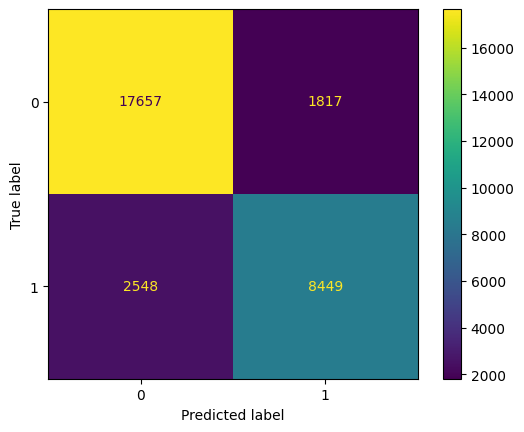

In [51]:
# Entrenar el modelo empleando 'class_weight'
clf_RF_cw = RandomForestClassifier(random_state = 42, class_weight = "balanced")
clf_RF_cw.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_cw = clf_RF_cw.predict(X_test)
print(classification_report(y_test, y_pred_RF_cw))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_cw);

### 4.4 **Optimizacion de hiperparametros**  
Durante el estudio se han empleado varias opciones de optimización de hiperparámetros:
* GridSearchCV
* Optuna

Una vez comprobado que el mejor resultado se obtiene aplicando una evaluación con **Optuna** se prueba también a mejorar el resultado con una selección de features (método 'wrapper').  
La mejora que se obtiene con la selección es mínima por lo que finalmente **se descarta emplear técnicas de selección de features**.

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     19474
           1       0.81      0.78      0.80     10997

    accuracy                           0.86     30471
   macro avg       0.85      0.84      0.84     30471
weighted avg       0.86      0.86      0.86     30471



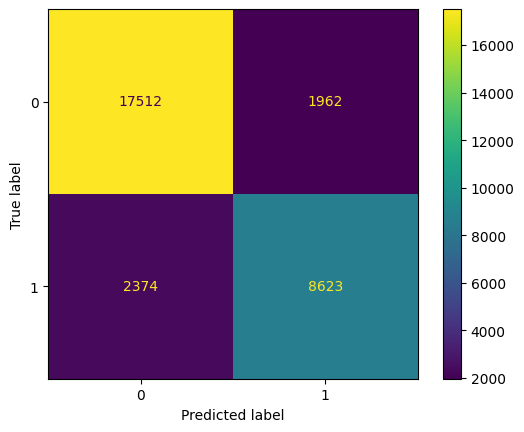

In [52]:
# Entrenar el modelo indicando los mejores parámetros
clf_RF_opcw = RandomForestClassifier(criterion = "log_loss", n_estimators = 290, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = None, class_weight = "balanced", random_state = 42)
clf_RF_opcw.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_opcw = clf_RF_opcw.predict(X_test)
print(classification_report(y_test, y_pred_RF_opcw))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_opcw);

[Indice](#indice)

---

## 5 **Guardado del modelo**

### 5.1 **Pipeline**

In [53]:
# Se carga de nuevo el dataset original para aplicar todos los cambios en secuencia
df = pd.read_csv("./src/data/Datos_Reservas_full.csv")

# Se extrae la misma muestra aleatoria de mil registros
df_muestra = df.sample(1000, random_state = 42)

# Se elimina la muestra del dataset original
df = df[~df.isin(df_muestra).all(axis=1)]

# Se separan los conjuntos de datos de train y test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

# Se forman los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = [target], inplace = True)
y_train = train_set[target].copy()

X_test = test_set.copy()
X_test.drop(columns = [target], inplace = True)
y_test = test_set[target].copy()

In [54]:
# Procesado a través de función
processor = FunctionTransformer(total_transform)

# Se añade el modelo con los ajustes establecidos previamente
pipeline_RFC = Pipeline(
    [("Procesado", processor),
     ("Classifier", RandomForestClassifier(criterion = "log_loss", n_estimators = 290, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = None, class_weight = "balanced", random_state = 42))])

pipeline_RFC

Pipeline(steps=[('Procesado',
                 FunctionTransformer(func=<function total_transform at 0x000001C781C16160>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=30,
                                        max_features=None, n_estimators=290,
                                        random_state=42))])

In [55]:
# Se entrena el modelo
pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('Procesado',
                 FunctionTransformer(func=<function total_transform at 0x000001C781C16160>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=30,
                                        max_features=None, n_estimators=290,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     19474
           1       0.81      0.78      0.80     10997

    accuracy                           0.86     30471
   macro avg       0.85      0.84      0.84     30471
weighted avg       0.86      0.86      0.86     30471



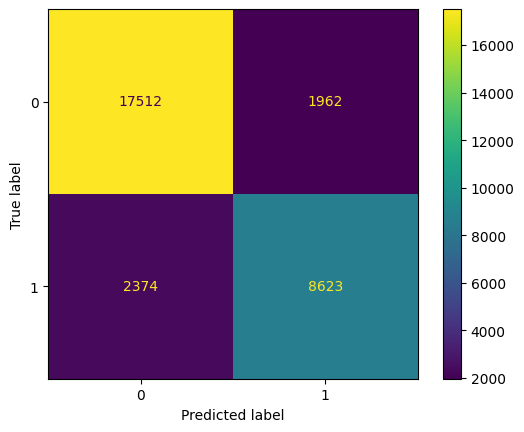

In [56]:
# Evaluación
y_pred_pipeline = pipeline_RFC.predict(X_test)
print(classification_report(y_test, y_pred_pipeline))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pipeline);

### 5.2 **Guardado**

In [266]:
# Se guarda el modelo con pickle:
with open("./src/models/model_pl_RF.pkl", "wb") as archivo:
    pickle.dump(pipeline_RFC, archivo)

[Indice](#indice)

---